In [143]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
signnames.csv  test.p  train.p	valid.p


In [144]:
import numpy as np
import tensorflow.keras
import random
import matplotlib.pyplot as plt
import random
import pickle
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical 
np.random.seed(0)

In [145]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [146]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']


In [147]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


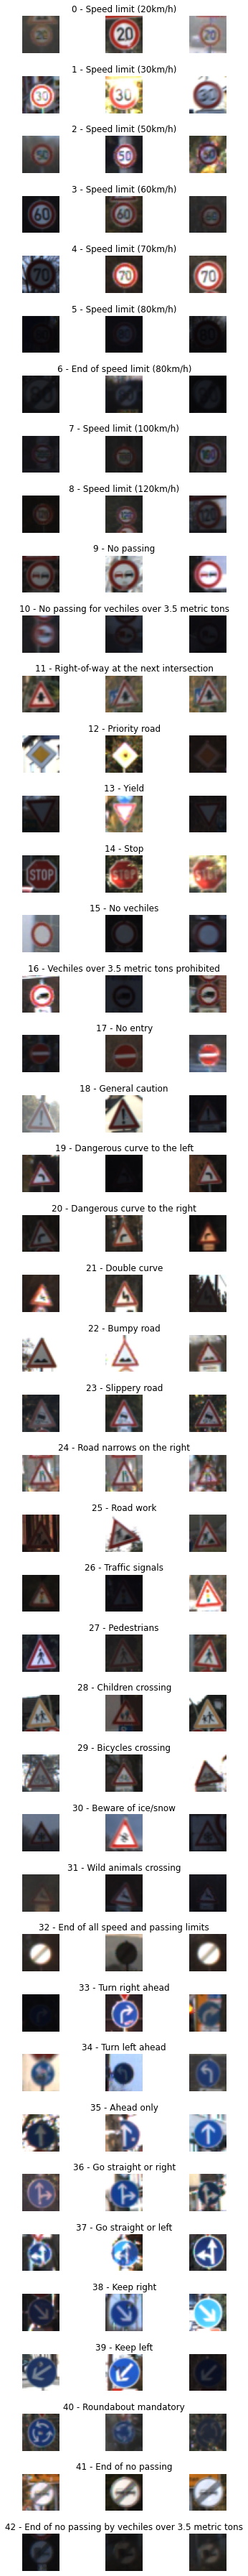

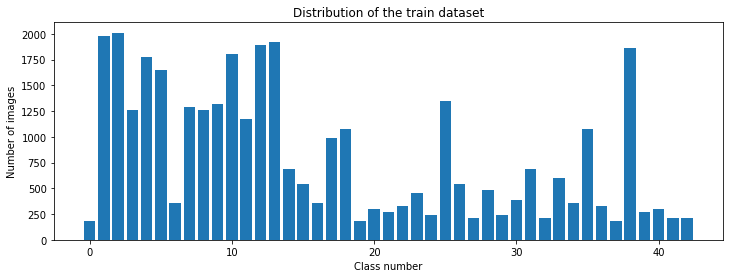

In [148]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]
cols = 3
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 1:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


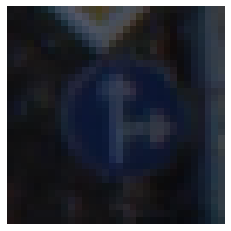

In [149]:
import cv2

test_image_number = 1000
plt.imshow(X_train[test_image_number])
plt.axis("off")
print(X_train[test_image_number].shape)
print(y_train[test_image_number])

(32, 32)


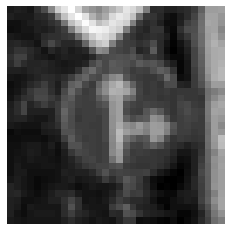

In [150]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

img = grayscale(X_train[test_image_number])
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

(32, 32)


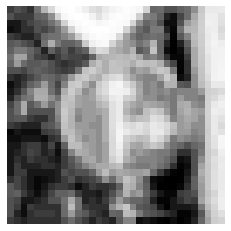

In [151]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
    
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

(34799, 32, 32)


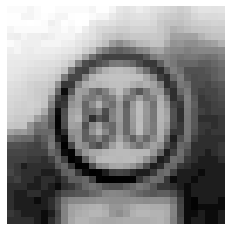

In [152]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap='gray')
plt.axis('off')
print(X_train.shape)

In [153]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

(50, 32, 32, 1)


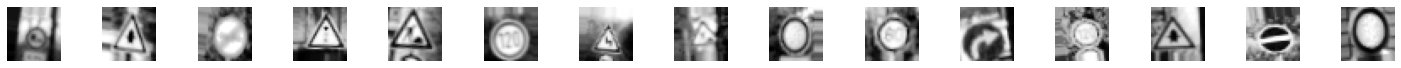

In [154]:
# Augmented images generation
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 50)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
    axs[i].axis("off")
 
print(X_batch.shape)

In [155]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [156]:
# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [157]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [158]:
# Train model
batch_Size = 100
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_Size),
                            steps_per_epoch=len(X_train)//batch_Size,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
347/347 [==============================] - 19s 53ms/step - loss: 1.9601 - accuracy: 0.4491 - val_loss: 0.3929 - val_accuracy: 0.8868
Epoch 2/10
347/347 [==============================] - 18s 51ms/step - loss: 0.6832 - accuracy: 0.7890 - val_loss: 0.1943 - val_accuracy: 0.9413
Epoch 3/10
347/347 [==============================] - 18s 51ms/step - loss: 0.4188 - accuracy: 0.8707 - val_loss: 0.1266 - val_accuracy: 0.9569
Epoch 4/10
347/347 [==============================] - 20s 57ms/step - loss: 0.3040 - accuracy: 0.9053 - val_loss: 0.0723 - val_accuracy: 0.9787
Epoch 5/10
347/347 [==============================] - 18s 52ms/step - loss: 0.2408 - accuracy: 0.9239 - val_loss: 0.0666 - val_accuracy: 0.9812
Epoch 6/10
347/347 [==============================] - 17s 50ms/step - loss: 0.1944 - accuracy: 0.9392 - val_loss: 0.0736 - val_accuracy: 0.9753
Epoch 7/10
347/347 [==============================] - 18s 50ms/step - loss: 0.1713 - accuracy: 0.9458 - val_loss: 0.0510 - val_accuracy:

Text(0.5, 0, 'epoch')

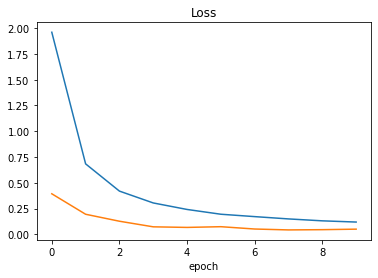

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

X_train.shape[0]/50 695.98


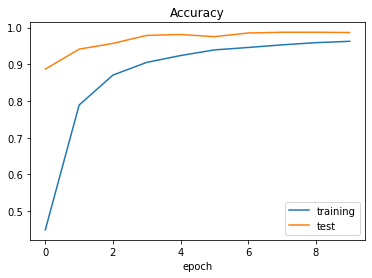

In [160]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
print("X_train.shape[0]/50", X_train.shape[0]/50)

In [161]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.10574904829263687
Test accuracy: 0.9687252640724182


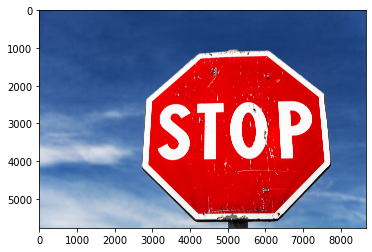

In [165]:
#predict internet number
import requests
from PIL import Image
url = 'https://imageio.forbes.com/specials-images/dam/imageserve/1137653208/0x0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)
[14]
predicted sign: Stop


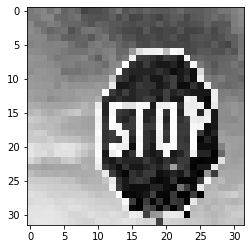

In [166]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))  
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
predict_x = model.predict(img) 
prediction = np.argmax(predict_x, axis=1)
keys = list(data['ClassId'].dropna())
values = list(data['SignName'].dropna())
map_values = dict(zip(keys, values))

print("predicted sign: "+ map_values.get(prediction[0]))
